# Example Python Scripting for ELEMENTS Backend and Geospatial Analytics
#### *This script was create by Matthew Schmitt for the RAA ELEMENTS Hands on Session (Febuary 15th, 2016). Please don't hesitate to send specific scripting questions to Matthew.Schmitt@aonbenfield.com.*
___
## Table of Contents
    + [Import Libraries](#lib)
    + [Set up DB Connections](#db)
    + [Import DB to Dataframe](#df)
    + [Messing around with the data](#dfstats)
    + [Geospatial Analytics](#geo)


### Importing the Libraries <a id="lib"></a>
*Python is an incredibly testy enviornment to work with outside of unix systems. For this matter I suggest you install Anaconda (link)[http://docs.continuum.io/anaconda/install] and work from there. Setting up a virtual environment is beyond the scope of this tutorial but it's suggested...

In [14]:
%matplotlib inline
import pyodbc, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)
pd.set_option('precision', 4)
pd.set_option('expand_frame_repr', True)
pd.set_option('display.mpl_style', 'default')

### Setting up DB connections <a id="db"></a>
*You will have to tailor some of these variables to your specific ELEMENTS set-up. Please visit [Impact Forecasting's support site](https://support.impactforecasting.com/) or emial: <ifsupport@aonbenfield.com>

* *Please be aware that for the sake of this tutorial I have used XXXX for the password and the user for security reasons...

In [2]:
dbstr = 'DRIVER={SQL Server};SERVER=nachiifrd001\\rd;UID=XXXX;PWD=XXXX'
dbcon = pyodbc.connect(dbstr)

In [3]:
# Here's our project name and portfolio information for the run...
projectname = 'mrs_aal_huc07'
portfolioid = 2
analysisid = 3
# This SQL query was made specifically to pull out Ground Up Average Annual Loss, please contact the author or IF support for help customizing this script for your intended purposes..
sql = "SELECT Prop.PropertyID, PROP.ExtPropertyID, ADDR.StateAbbreviation, NumOfStories, YearBuilt, BuildingType, OccupancyType, BasementClass, Addrmatch, Addr.Latitude/1000000. GeoLat, ADDR.Longitude/1000000. GeoLon, ADDR.PostalCode GeoZip, Elevation Elevation_cm ,SITE.STR_TIV, SITE.CON_TIV, SITE.TE_TIV, AAL.GU GU_AAL FROM (SELECT * FROM IF_EXP_%s.dbo.property WHERE PortfolioID = %i) PROP FULL JOIN (SELECT * FROM IF_EXP_%s.dbo.site WHERE PortfolioID = %i) SITE ON PROP.ExtPropertyID = Site.ExtSiteID FULL JOIN (SELECT * FROM IF_EXP_%s.dbo.Address WHERE PortfolioID = %i) ADDR ON PROP.EXTPropertyID = ADDR.ExtPropertyID FULL JOIN (SELECT * FROM IF_RES_%s.dbo.PML WHERE PMLLevelType = 'LOCATION' AND AnalysisRunID = %i AND RetPeriod = 0) AAL ON AAL.RefID = PROP.PropertyID" % (projectname,portfolioid,projectname,portfolioid,projectname,portfolioid,projectname,analysisid)
print sql

SELECT Prop.PropertyID, PROP.ExtPropertyID, ADDR.StateAbbreviation, NumOfStories, YearBuilt, BuildingType, OccupancyType, BasementClass, Addrmatch, Addr.Latitude/1000000. GeoLat, ADDR.Longitude/1000000. GeoLon, ADDR.PostalCode GeoZip, Elevation Elevation_cm ,SITE.STR_TIV, SITE.CON_TIV, SITE.TE_TIV, AAL.GU GU_AAL FROM (SELECT * FROM IF_EXP_mrs_aal_huc07.dbo.property WHERE PortfolioID = 2) PROP FULL JOIN (SELECT * FROM IF_EXP_mrs_aal_huc07.dbo.site WHERE PortfolioID = 2) SITE ON PROP.ExtPropertyID = Site.ExtSiteID FULL JOIN (SELECT * FROM IF_EXP_mrs_aal_huc07.dbo.Address WHERE PortfolioID = 2) ADDR ON PROP.EXTPropertyID = ADDR.ExtPropertyID FULL JOIN (SELECT * FROM IF_RES_mrs_aal_huc07.dbo.PML WHERE PMLLevelType = 'LOCATION' AND AnalysisRunID = 3 AND RetPeriod = 0) AAL ON AAL.RefID = PROP.PropertyID


### Pulling to dataframe using Pandas <a id="df"></a>
*Now that we have the information in a SQL string, it's easy to use the pandas module to pull into a dataframe

In [6]:
# Pandas uses the SQL string and the connection string we created in the cells above to pull from the ELEMENTS DB.
%time data = pd.read_sql(sql, dbcon)
data.head()

Wall time: 1min 30s


,PropertyID,ExtPropertyID,StateAbbreviation,NumOfStories,YearBuilt,BuildingType,OccupancyType,BasementClass,Addrmatch,GeoLat,GeoLon,GeoZip,Elevation_cm,STR_TIV,CON_TIV,TE_TIV,GU_AAL
0,23746,2882885,MN,0.00,1980,WD,R,UNK,1,44.14,-94.63,56056,31022,"100,000.00","50,000.00","20,000.00",60.38
1,23848,2882987,MN,0.00,1980,WD,R,UNK,1,46.84,-93.35,55752,37482,"100,000.00","50,000.00","20,000.00",6.33
2,23882,2883021,WI,0.00,1980,WD,R,UNK,1,43.25,-89.41,53571,30024,"100,000.00","50,000.00","20,000.00",nan
3,23912,2883051,WI,0.00,1980,WD,R,UNK,1,44.65,-89.48,54423,34944,"100,000.00","50,000.00","20,000.00",0.44
4,23946,2883085,IA,0.00,1980,WD,R,UNK,1,41.36,-94.17,50070,34276,"100,000.00","50,000.00","20,000.00",377.71


In [7]:
# Print the number of rows, or the length of the data frame
print "Total Policies in Analysis: "+ str('{:,.2f}'.format(len(data)))
print "Total Policies with GU AAL: " + str('{:,.2f}'.format(data.GU_AAL.count()))
print "Percent of Portfolio with GU AAL: " + str('{:,.2f}'.format((float(data.GU_AAL.count())/float(len(data)))*100)) + "%"

Total Policies in Analysis: 2,978,409.00
Total Policies with GU AAL: 2,229,920.00
Percent of Portfolio with GU AAL: 74.87%


In [9]:
# Check the data types to make sure we don't have any strings or objects in our numerical columns
data.dtypes

PropertyID             int64
ExtPropertyID          int64
StateAbbreviation     object
NumOfStories         float64
YearBuilt              int64
BuildingType          object
OccupancyType         object
BasementClass         object
Addrmatch              int64
GeoLat               float64
GeoLon               float64
GeoZip                object
Elevation_cm           int64
STR_TIV              float64
CON_TIV              float64
TE_TIV               float64
GU_AAL               float64
dtype: object

In [10]:
# The final column, GU_AAL, has Pandas (also Numpy's) version of NULL, or NaN. This value is harmless if using pandas, 
# but if you wanted to compute statistics and have them include the NaN as 0 values, then it's easier to change it.
# I'm going to clean up the Dataframe to my personal liking:
# NOTE: YOU MAY WANT TO KEEP PROPERTYID AND EXTPROPERTYID BECAUSE THEY ARE THE KEY TO YOUR PORTFOLIO
data = data.drop(['PropertyID','ExtPropertyID','YearBuilt','BasementClass','Addrmatch','NumOfStories','OccupancyType','BuildingType'], axis=1)
# Lowercase the columns, it's a personal habit of mine...
data.columns = map(str.lower, data.columns)
# Change all NaNs to 0 (useful before loading to a db)
data = data.fillna(0)
data['totaltiv']=data['str_tiv']+data['con_tiv']+data['te_tiv']
data['losscost_1k']=(data['gu_aal']/data['totaltiv'])*1000
data = data.drop(['str_tiv','con_tiv','te_tiv'], axis=1)
data.head()

,stateabbreviation,geolat,geolon,geozip,elevation_cm,gu_aal,totaltiv,losscost_1k
0,MN,44.14,-94.63,56056,31022,60.38,"170,000.00",0.36
1,MN,46.84,-93.35,55752,37482,6.33,"170,000.00",0.04
2,WI,43.25,-89.41,53571,30024,0.00,"170,000.00",0.00
3,WI,44.65,-89.48,54423,34944,0.44,"170,000.00",0.00
4,IA,41.36,-94.17,50070,34276,377.71,"170,000.00",2.22


In [15]:
data = data.sort_values(['stateabbreviation','geozip'], ascending=False)
data.head()

,stateabbreviation,geolat,geolon,geozip,elevation_cm,gu_aal,totaltiv,losscost_1k
8985,WI,43.74,-88.67,54974,27851,97.89,"170,000.00",0.58
12131,WI,43.73,-88.66,54974,27673,11.54,"170,000.00",0.07
13190,WI,43.74,-88.67,54974,28016,0.00,"170,000.00",0.00
15131,WI,43.73,-88.65,54974,27592,0.00,"170,000.00",0.00
54720,WI,43.74,-88.70,54974,28506,109.08,"170,000.00",0.64


### Some Useful Statistics <a id="dfstats"></a>

In [21]:
# Describe is a very simple way to go about this
data[['gu_aal', 'losscost_1k']].describe()

,gu_aal,losscost_1k
count,"2,978,409.00","2,978,409.00"
mean,"1,309.23",7.70
std,"3,598.41",21.17
min,0.00,0.00
25%,0.00,0.00
50%,58.50,0.34
75%,793.80,4.67
max,"37,926.86",223.10


In [20]:
# Also calculate the variance becasue that's not part of .describe()
print "Ground up AAL:"
print "Max: "+str('${:,.2f}'.format(data.gu_aal.max()))
print "Standard Deviation: "+str('${:,.2f}'.format(data.gu_aal.std()))
print "Variance: "+str('${:,.2f}'.format(data.gu_aal.var()))
print '\n'
# The loss cost is per $1,000 dollars, we can get some summary statistics with the following:
print "Loss Cost per $1,000:"
print "Max: " + str('${:,.2f}'.format(data.losscost_1k.max()))
print "Standard Deviation: " + str('${:,.2f}'.format(data.losscost_1k.std()))
print "Variance: " + str('${:,.2f}'.format(data.losscost_1k.var()))

Ground up AAL:
Max: $37,926.86
Standard Deviation: $3,598.41
Variance: $12,948,552.48


Loss Cost per $1,000:
Max: $223.10
Standard Deviation: $21.17
Variance: $448.05


In [24]:
# We can use to groupby method to get descriptions for each individual state and aggregate
data[['stateabbreviation','gu_aal']].groupby('stateabbreviation').sum()

,gu_aal
stateabbreviation,
IA,"975,661,541.16"
IL,"1,138,486,239.20"
IN,"22,919,659.22"
KY,"1,208,334.91"
MN,"543,613,314.77"
MO,"717,634,815.95"
SD,"7,631,859.76"
WI,"492,269,820.83"


In [41]:
# We can drill down to the zipcode level if we really wanted too...
df = data.loc[data['stateabbreviation']=='IL']
df = df.drop(['stateabbreviation','geolat','geolon','elevation_cm','elevation_cm'], axis=1)
df.groupby(['geozip']).aggregate([sum, len])

gu_aal                  totaltiv          losscost_1k         
                 sum      len              sum      len         sum      len
geozip                                                                      
46213      36,945.19    71.00    12,070,000.00    71.00      217.32    71.00
60000           0.00    10.00     1,700,000.00    10.00        0.00    10.00
60001       7,976.42   210.00    35,700,000.00   210.00       46.92   210.00
60002      85,676.37   531.00    90,270,000.00   531.00      503.98   531.00
60004       9,021.98    30.00     5,100,000.00    30.00       53.07    30.00
60005         423.54    13.00     2,210,000.00    13.00        2.49    13.00
60006      55,416.08    91.00    15,470,000.00    91.00      325.98    91.00
60007      80,883.41   198.00    33,660,000.00   198.00      475.78   198.00
60008      49,990.64   118.00    20,060,000.00   118.00      294.06   118.00
60009       3,042.78    41.00     6,970,000.00    41.00       17.90    41.00
60010      73,008.13   293.00    49,810,000.00   293.00      429.46   293.00
60011      11,516.75   126.00    21,420,000.00   126.00       67.75   126.00
60012      10,931.10   158.00    26,860,000.00   158.00       64.30   158.00
60013     566,762.53   332.00    56,440,000.00   332.00    3,333.90   332.00
60014       5,216.20   133.00    22,610,000.00   133.00       30.68   133.00
60015     143,172.93    90.00    15,300,000.00    90.00      842.19    90.00
60016     536,833.77   388.00    65,960,000.00   388.00    3,157.85   388.00
60017      11,912.99    89.00    15,130,000.00    89.00       70.08    89.00
60018      21,570.65   103.00    17,510,000.00   103.00      126.89   103.00
60019      41,287.72    31.00     5,270,000.00    31.00      242.87    31.00
60020   1,107,018.75 1,781.00   302,770,000.00 1,781.00    6,511.88 1,781.00
60021     519,988.30   290.00    49,300,000.00   290.00    3,058.75   290.00
60022      61,710.69   160.00    27,200,000.00   160.00      363.00   160.00
60025      30,033.37    38.00     6,460,000.00    38.00      176.67    38.00
60026         268.67     4.00       680,000.00     4.00        1.58     4.00
...              ...      ...              ...      ...         ...      ...
62952  10,077,896.72 3,019.00   513,230,000.00 3,019.00   59,281.75 3,019.00
62956       1,472.39    19.00     3,230,000.00    19.00        8.66    19.00
62957  24,762,738.75 3,939.00   669,630,000.00 3,939.00  145,663.17 3,939.00
62958      55,108.51   252.00    42,840,000.00   252.00      324.17   252.00
62959     704,258.00 1,053.00   179,010,000.00 1,053.00    4,142.69 1,053.00
62961      38,018.29   292.00    49,640,000.00   292.00      223.64   292.00
62962  44,933,957.43 6,200.00 1,054,000,000.00 6,200.00  264,317.40 6,200.00
62964      13,845.04    13.00     2,210,000.00    13.00       81.44    13.00
62966   3,866,748.75   853.00   145,010,000.00   853.00   22,745.58   853.00
62969   1,654,777.46 1,064.00   180,880,000.00 1,064.00    9,733.99 1,064.00
62970      10,989.49   102.00    17,340,000.00   102.00       64.64   102.00
62971     420,653.24   786.00   133,620,000.00   786.00    2,474.43   786.00
62973     626,612.03 1,524.00   259,080,000.00 1,524.00    3,685.95 1,524.00
62974      94,710.25   246.00    41,820,000.00   246.00      557.12   246.00
62975   1,863,407.91   625.00   106,250,000.00   625.00   10,961.22   625.00
62976     604,527.04 1,256.00   213,520,000.00 1,256.00    3,556.04 1,256.00
62983     235,142.54   302.00    51,340,000.00   302.00    1,383.19   302.00
62988     152,499.61   644.00   109,480,000.00   644.00      897.06   644.00
62990   4,782,709.77   626.00   106,420,000.00   626.00   28,133.59   626.00
62992     886,073.31 1,518.00   258,060,000.00 1,518.00    5,212.20 1,518.00
62993     780,020.11 1,136.00   193,120,000.00 1,136.00    4,588.35 1,136.00
62994   1,283,491.92 1,770.00   300,900,000.00 1,770.00    7,549.95 1,770.00
62997      11,120.68    47.00     7,990,000.00    47.00       65.42    47.00
62998  30,

### Geospatial Analysis <a id="geo"></a>
   

In [93]:
%matplotlib inline
import folium
import fiona.crs
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import Normalize
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm
plt.style.use('ggplot')

In [96]:
# Let's create a new Dataframe with only points that have AAL values...
df = data.loc[data['gu_aal']>0]
df = df.loc[df['geozip']=='62999']
df.gu_aal.count()

926

In [97]:
# This part is VERY MEMORY INTENSIVE please be careful...
# The output is a Shapely geometry point, which we will then recombine into a 
# Geodataframe or a Geoseries... This is to show you how fast we can create a shapefile..
# For reference: 
# ~ half a million points took 14.4s
# ~2.3million points took 1 minute 5 seconds!
%time geometry = [Point(xy) for xy in zip(df.geolon, df.geolat)]

Wall time: 39 ms


In [98]:
# Combine that into a geospatial DF from geopandas and you'll see there's now a geometry column
geo_df = gpd.GeoDataFrame(df,crs=fiona.crs.from_epsg(4326), geometry=geometry)
# Create an index on the two government unit columns we have to speed things up a bit
geo_df.set_index(['stateabbreviation', 'geozip'], inplace=True)
# And sort the index
geo_df.sort_index()
geo_df.head()

geolat  geolon  elevation_cm   gu_aal   totaltiv  \
stateabbreviation geozip                                                     
IL                62999    37.89  -89.03         11285 1,003.23 170,000.00   
                  62999    37.86  -89.07         11065 5,346.17 170,000.00   
                  62999    37.90  -89.02         11518    56.82 170,000.00   
                  62999    37.86  -89.06         11126   786.83 170,000.00   
                  62999    37.88  -89.07         11373    26.98 170,000.00   

                          losscost_1k                              geometry  
stateabbreviation geozip                                                     
IL                62999          5.90             POINT (-89.026 37.885002)  
                  62999         31.45     POINT (-89.06600899999999 37.861)  
                  62999          0.33           POINT (-89.02301 37.903999)  
                  62999          4.63  POINT (-89.06399500000001 37.863998)  
                  62999          0.16             POINT (-89.066986 37.875)

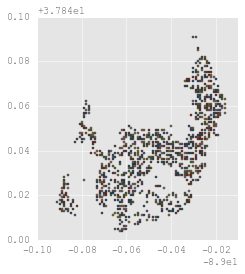

In [99]:
geo_df.plot()

In [100]:
# If you wanted to output the file right now as a geojson you could run this code:
with open('aal_points.geojson', 'w') as f:
    f.write(geo_df.to_json())

In [101]:
# Or you could just save it as a Shapefile:
geo_df.to_file('aal_points.shp')
# Note, it truncated my attribute name because they were too long for the shapefile format